# Adversarial Attacks with ResNet-34 (Updated)

This notebook performs two tasks on a 100-class subset of ImageNet-1K:
1. Evaluate clean top-1/top-5 accuracy using a pretrained ResNet-34.
2. Generate adversarial examples using FGSM (ε=0.02), re-evaluate accuracy, and visualize misclassifications with human-readable labels.


## 1. Imports and Preprocessing

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json, random

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); random.seed(0); np.random.seed(0)
# Normalization constants
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms  = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms),
])

## 2. Task 1: Clean Accuracy Evaluation

In [2]:
# Load dataset
dataset = datasets.ImageFolder(
    root="TestDataSet",
    transform=plain_transforms
)




loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=4)

# Load mapping for 401–500 indices
with open("TestDataSet/labels_list.json") as f:
    entries = json.load(f)
idx_to_true = {i: int(entries[i].split(":",1)[0]) for i in range(len(entries))}

# Load pretrained ResNet-34
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval().to(device)

# Evaluate clean accuracy
top1 = top5 = total = 0
with torch.no_grad():
    for imgs, labels in tqdm(loader, desc="Clean Eval"):
        imgs = imgs.to(device)
        logits = model(imgs)
        _, p5 = logits.topk(5, dim=1)
        true = torch.tensor([idx_to_true[int(l)] for l in labels], device=p5.device)
        top1 += (p5[:,0] == true).sum().item()
        top5 += (p5 == true.unsqueeze(1)).any(dim=1).sum().item()
        total += labels.size(0)

print(f"Clean Top-1 accuracy: {top1/total*100:.2f}%")
print(f"Clean Top-5 accuracy: {top5/total*100:.2f}%")

Clean Eval: 100%|██████████| 4/4 [00:00<00:00,  8.66it/s]

Clean Top-1 accuracy: 76.00%
Clean Top-5 accuracy: 94.20%


## 3. Task 2: FGSM Attack & Adversarial Evaluation

In [3]:
# FGSM helper
cn = torch.tensor(mean_norms, device=device)[:,None,None]
cs = torch.tensor(std_norms,  device=device)[:,None,None]
min_val = (0 - cn) / cs
max_val = (1 - cn) / cs

def fgsm(image, eps, grad):
    return torch.max(torch.min(image + eps*grad.sign(), max_val), min_val)

# Single-image loader
si_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

# Run FGSM
epsilon = 0.02
adv_images, adv_labels, orig_preds, adv_preds = [], [], [], []

for img, lab in tqdm(si_loader, desc="FGSM"):
    img = img.to(device).detach().requires_grad_(True)
    lab = lab.to(device)
    out = model(img)
    true_idx = torch.tensor([idx_to_true[int(lab)]], device=device)
    loss = F.cross_entropy(out, true_idx)
    model.zero_grad(); loss.backward()
    adv = fgsm(img, epsilon, img.grad.data).detach().to(torch.float32)
    adv_images.append(adv.squeeze(0).cpu())
    adv_labels.append(int(lab))
    orig_preds.append(out.argmax(1).item())
    adv_preds.append(model(adv).argmax(1).item())

# Build adversarial set
adv_tensor = torch.stack(adv_images)
lab_tensor = torch.tensor(adv_labels)
adv_set = TensorDataset(adv_tensor, lab_tensor)
adv_loader = DataLoader(adv_set, batch_size=32, shuffle=False)

# Evaluate adversarial set
top1 = top5 = total = 0
with torch.no_grad():
    for imgs, labs in adv_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        _, p5 = out.topk(5,1)
        true = torch.tensor([idx_to_true[int(l)] for l in labs], device=p5.device)
        top1 += (p5[:,0]==true).sum().item()
        top5 += (p5==true.unsqueeze(1)).any(1).sum().item()
        total += labs.size(0)
print(f"Adversarial top-1: {top1/total*100:.2f}%")
print(f"Adversarial top-5: {top5/total*100:.2f}%")


FGSM: 100%|██████████| 500/500 [00:03<00:00, 164.00it/s]


Adversarial top-1: 6.20%
Adversarial top-5: 35.40%


## 4. Visualization of Misclassifications

NameError: name 'orig_images' is not defined

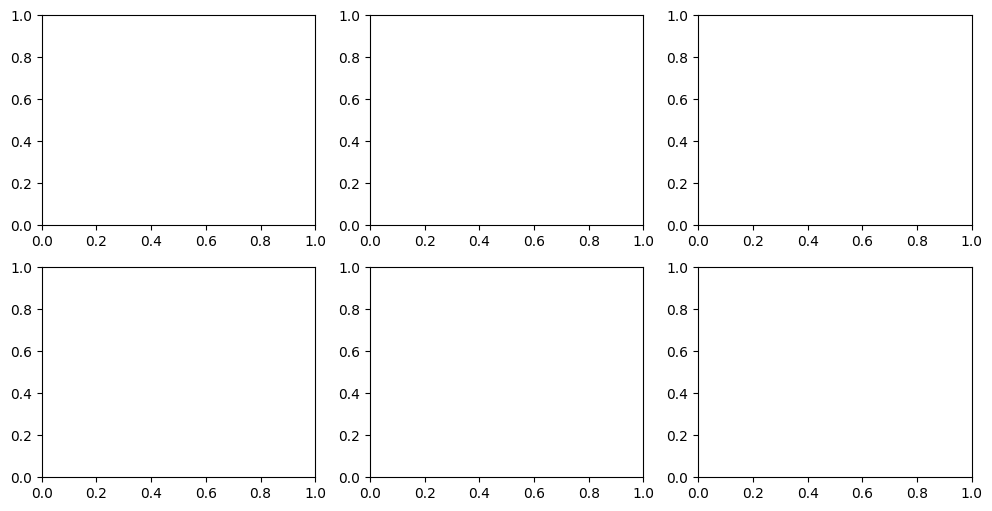

In [5]:
# Prepare label maps for human-readable names
weights = models.ResNet34_Weights.IMAGENET1K_V1
all_labels = weights.meta['categories']
label_401_to_500 = {i: all_labels[i] for i in range(401, 501)}

# Find 3 examples where clean was correct but adv is misclassified
picked = []
for i, (o, a, l) in enumerate(zip(orig_preds, adv_preds, adv_labels)):
    true_img_idx = idx_to_true[l]
    if o == true_img_idx and a != true_img_idx:
        picked.append(i)
    if len(picked) >= 5:
        break

# Un-normalizer
inv_norm = transforms.Normalize(
    mean=(-mean_norms / std_norms).tolist(),
    std=(1 / std_norms).tolist()
)

# Plot
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for col, i in enumerate(picked):
    true_idx = idx_to_true[adv_labels[i]]
    adv_idx = adv_preds[i]

    true_name = label_401_to_500[true_idx]
    adv_name = all_labels[adv_idx]

    for row, img in enumerate([orig_images[i], adv_images[i]]):
        ax = axes[row, col]
        # im = inv_norm(img).permute(1, 2, 0).clamp(0, 1).numpy()
        im = inv_norm(img).permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()

        ax.imshow(im)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"orig\ntrue={true_name}")
        else:
            ax.set_title(f"adv\npred={adv_name}")
plt.tight_layout()
plt.show()

# Task3:  Improved attacks （PGD Without Target Attacks）

In [7]:


# ------------------- Parameters -------------------
eps   = 0.02
steps = 10

args = {
    "data":      "TestDataSet",
    "labels":    "TestDataSet/labels_list.json",
    "eps":       eps,
    "steps":     steps,
    "alpha":     eps / steps,   
    "batch":     128,
    "workers":   8,
    "rand_start": True,
    "out":       "adv_set_pgd.pt"
}





# ------------------- ImageNet normalization -------------------
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
normalize = transforms.Normalize(mean.tolist(), std.tolist())

eps_n   = torch.tensor(args["eps"]   / std, device=device, dtype=torch.float32).view(3,1,1)
alpha_n = torch.tensor(args["alpha"] / std, device=device, dtype=torch.float32).view(3,1,1)
std_tensor = torch.tensor(std, device=device, dtype=torch.float32).view(3,1,1)

min_val = torch.tensor(((0 - mean) / std).reshape(3,1,1), device=device)
max_val = torch.tensor(((1 - mean) / std).reshape(3,1,1), device=device)

# ------------------- PGD Attack Function -------------------
def pgd_attack(model, x, y, eps_n, alpha_n, steps, min_v, max_v, rand_start):
    if rand_start:
        x_adv = x + torch.empty_like(x).uniform_(-1, 1) * eps_n
        x_adv = torch.clamp(x_adv, min_v, max_v)
    else:
        x_adv = x.clone()

    for _ in range(steps):
        x_adv = x_adv.detach().requires_grad_(True)
        model.zero_grad(set_to_none=True)
        F.cross_entropy(model(x_adv), y).backward()
        grad_sign = x_adv.grad.sign()
        x_adv = x_adv + alpha_n * grad_sign
        x_adv = torch.clamp(x_adv, x - eps_n, x + eps_n)
        x_adv = torch.clamp(x_adv, min_v, max_v)
    return x_adv.detach()

# ------------------- Load Dataset -------------------
transform = transforms.Compose([transforms.ToTensor(), normalize])
dataset   = datasets.ImageFolder(root=args["data"], transform=transform)
loader    = DataLoader(dataset, batch_size=args["batch"], shuffle=False, num_workers=args["workers"])

with open(args["labels"]) as f:
    idx2true = {i: int(e.split(":",1)[0]) for i, e in enumerate(json.load(f))}

# ------------------- Load Pretrained Model -------------------
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)
model.eval()

# ------------------- Evaluation Function -------------------
@torch.no_grad()
def evaluate(model, loader, idx2true, device, tag=""):
    top1 = top5 = tot = 0
    for x, labs in loader:
        x = x.to(device, non_blocking=True)
        labs = torch.tensor([idx2true[int(l)] for l in labs], device=device)
        logits = model(x)
        top1 += (logits.argmax(1) == labs).sum().item()
        top5 += (logits.topk(5, 1)[1] == labs[:, None]).any(1).sum().item()
        tot  += labs.size(0)
    print(f"{tag:<8}Top‑1 {top1/tot*100:6.2f}%   Top‑5 {top5/tot*100:6.2f}%")
    return top1 / tot, top5 / tot

# ------------------- Evaluate Clean Accuracy -------------------
evaluate(model, loader, idx2true, device, "Clean")

# ------------------- PGD Attack Loop -------------------
adv_batches, lab_batches = [], []
for x, labs in loader:
    x = x.to(device, non_blocking=True)
    y = torch.tensor([idx2true[int(l)] for l in labs], device=device)

    adv = pgd_attack(model, x, y, eps_n, alpha_n,
                     args["steps"], min_val, max_val, args["rand_start"])
    
    raw_delta = ((adv - x).abs() * std_tensor).max().item()
    assert raw_delta <= args["eps"] + 1e-6, f"ε-constraint {raw_delta:.6f} > ε"

    adv_batches.append(adv)
    lab_batches.append(labs.to(device))

adv_tensor = torch.cat(adv_batches)
lab_tensor = torch.cat(lab_batches)

# ------------------- Evaluate PGD Accuracy -------------------
pgd_loader = DataLoader(TensorDataset(adv_tensor, lab_tensor),
                        batch_size=args["batch"])
evaluate(model, pgd_loader, idx2true, device, "PGD")

# ------------------- Save Dataset -------------------
torch.save({"images": adv_tensor.cpu(), "labels": lab_tensor.cpu()}, args["out"])
print(f"\nSaved Adversarial Test Set 2 → {args['out']}")


Clean   Top‑1  76.00%   Top‑5  94.20%
PGD     Top‑1   0.00%   Top‑5   2.60%

Saved Adversarial Test Set 2 → adv_set_pgd.pt


In [ ]:
import json, random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models

# ------------------- Parameters -------------------
args = {
    "data": "TestDataSet",
    "labels": "TestDataSet/labels_list.json",
    "eps": 0.02,
    "steps": 5,           # 比 FGSM 更强
    "alpha": 0.004,
    "batch": 64,
    "workers": 4,
    "target_class": 0,     # 所有图像强制扰动成这个类 (tench)
    "out": "adv_set_targeted.pt"
}

# ------------------- Device -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); random.seed(0); np.random.seed(0)

# ------------------- ImageNet normalization -------------------
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
normalize = transforms.Normalize(mean.tolist(), std.tolist())

eps_n   = torch.tensor(args["eps"]   / std, device=device, dtype=torch.float32).view(3,1,1)
alpha_n = torch.tensor(args["alpha"] / std, device=device, dtype=torch.float32).view(3,1,1)
std_tensor = torch.tensor(std, device=device, dtype=torch.float32).view(3,1,1)

min_val = torch.tensor(((0 - mean) / std).reshape(3,1,1), device=device)
max_val = torch.tensor(((1 - mean) / std).reshape(3,1,1), device=device)

# ------------------- Targeted PGD Function -------------------
def targeted_pgd(model, x, target, eps_n, alpha_n, steps, min_v, max_v):
    x_adv = x.clone()
    for _ in range(steps):
        x_adv = x_adv.detach().requires_grad_(True)
        model.zero_grad(set_to_none=True)
        loss = F.cross_entropy(model(x_adv), target)
        loss.backward()
        grad = x_adv.grad.sign()
        x_adv = x_adv - alpha_n * grad
        x_adv = torch.clamp(x_adv, x - eps_n, x + eps_n)
        x_adv = torch.clamp(x_adv, min_v, max_v)
    return x_adv.detach()

# ------------------- Load Dataset -------------------
transform = transforms.Compose([transforms.ToTensor(), normalize])
dataset   = datasets.ImageFolder(root=args["data"], transform=transform)
loader    = DataLoader(dataset, batch_size=args["batch"], shuffle=False, num_workers=args["workers"])

with open(args["labels"]) as f:
    idx2true = {i: int(e.split(":",1)[0]) for i, e in enumerate(json.load(f))}

# ------------------- Load Pretrained Model -------------------
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)
model.eval()

# ------------------- Evaluation Function -------------------
@torch.no_grad()
def evaluate(model, loader, idx2true, device, tag=""):
    top1 = top5 = tot = 0
    for x, labs in loader:
        x = x.to(device, non_blocking=True)
        labs = torch.tensor([idx2true[int(l)] for l in labs], device=device)
        logits = model(x)
        top1 += (logits.argmax(1) == labs).sum().item()
        top5 += (logits.topk(5, 1)[1] == labs[:, None]).any(1).sum().item()
        tot  += labs.size(0)
    print(f"{tag:<8}Top‑1 {top1/tot*100:6.2f}%   Top‑5 {top5/tot*100:6.2f}%")
    return top1 / tot, top5 / tot

# ------------------- Clean Accuracy -------------------
evaluate(model, loader, idx2true, device, "Clean")

# ------------------- Targeted Attack Loop -------------------
adv_batches, lab_batches = [], []
for x, labs in loader:
    x = x.to(device)
    target = torch.full_like(labs, fill_value=args["target_class"], device=device)

    adv = targeted_pgd(model, x, target, eps_n, alpha_n,
                       args["steps"], min_val, max_val)

    # Ensure constraint
    raw_delta = ((adv - x).abs() * std_tensor).max().item()
    assert raw_delta <= args["eps"] + 1e-6, f"ε-constraint {raw_delta:.6f} > ε"

    adv_batches.append(adv)
    lab_batches.append(labs.to(device))

adv_tensor = torch.cat(adv_batches)
lab_tensor = torch.cat(lab_batches)

# ------------------- Evaluate Targeted PGD Accuracy -------------------
adv_loader = DataLoader(TensorDataset(adv_tensor, lab_tensor), batch_size=args["batch"])
evaluate(model, adv_loader, idx2true, device, "Targeted")

# ------------------- Save Dataset -------------------
torch.save({"images": adv_tensor.cpu(), "labels": lab_tensor.cpu()}, args["out"])
print(f"\nSaved Adversarial Test Set 2 → {args['out']}")


Clean   Top‑1  76.00%   Top‑5  94.20%
TargetedTop‑1   0.80%   Top‑5   8.00%

Saved Adversarial Test Set 2 → adv_set_targeted.pt


In [ ]:
import json, random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# ───────────── Parameters ─────────────
args = {
    "data": "./TestDataSet",
    "labels": "./TestDataSet/labels_list.json",
    "eps": 0.3,
    "steps": 80,
    "alpha": 0.006,
    "batch": 16,
    "workers": 4,
    "target": 0,
    "out": "adv_set_patch_soft.pt"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); random.seed(0); np.random.seed(0)

# ───────────── Normalization ─────────────
mean = np.array([0.485, 0.456, 0.406], np.float32)
std  = np.array([0.229, 0.224, 0.225], np.float32)
normalize = transforms.Normalize(mean.tolist(), std.tolist())

eps_n   = torch.tensor(args["eps"]   / std, device=device).view(3,1,1)
alpha_n = torch.tensor(args["alpha"] / std, device=device).view(3,1,1)
min_v   = torch.tensor(((0 - mean)/std).reshape(3,1,1), device=device)
max_v   = torch.tensor(((1 - mean)/std).reshape(3,1,1), device=device)
std_t   = torch.tensor(std, device=device).view(3,1,1)

# ───────────── Gaussian blur ─────────────
def gaussian_blur(mask, k=15, sigma=6):
    coords = torch.arange(k, dtype=torch.float32, device=mask.device) - (k - 1) / 2
    kernel = torch.exp(-(coords**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    kernel = kernel.view(1, 1, 1, k)
    mask = F.conv2d(mask, kernel, padding=(0, k // 2), groups=1)
    mask = F.conv2d(mask, kernel.transpose(2, 3), padding=(k // 2, 0), groups=1)
    return mask

# ───────────── Attack Function ─────────────
def patch_pgd(model, x, tgt, mask, eps_n, alpha_n, steps, min_v, max_v):
    x_adv = x.clone()
    mom = torch.zeros_like(x)
    beta = 0.9
    for _ in range(steps):
        x_adv = x_adv.detach().requires_grad_(True)
        loss = F.cross_entropy(model(x_adv), tgt)
        loss.backward()
        grad = x_adv.grad.sign() * mask
        mom = beta * mom + grad
        x_adv = x_adv - alpha_n * mom.sign()
        x_adv = torch.max(torch.min(x_adv, x + eps_n * mask), x - eps_n * mask)
        x_adv = torch.clamp(x_adv, min_v, max_v)
    return x_adv.detach()

# ───────────── Dataset + Loader ─────────────
transform = transforms.Compose([transforms.ToTensor(), normalize])
dataset = datasets.ImageFolder(root=args["data"], transform=transform)
loader = DataLoader(dataset, batch_size=args["batch"], shuffle=False, num_workers=args["workers"])

with open(args["labels"]) as f:
    idx2true = {i: int(e.split(":",1)[0]) for i, e in enumerate(json.load(f))}

# ───────────── Model ─────────────
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)
model.eval()

# ───────────── Accuracy Function ─────────────
@torch.no_grad()
def evaluate(model, loader, idx2true, device, tag=""):
    t1 = t5 = n = 0
    for x, labs in loader:
        x = x.to(device)
        labs = torch.tensor([idx2true[int(l)] for l in labs], device=device)
        logits = model(x)
        t1 += (logits.argmax(1) == labs).sum().item()
        t5 += (logits.topk(5, 1)[1] == labs[:, None]).any(1).sum().item()
        n += labs.size(0)
    print(f"{tag:<10}Top‑1 {t1/n*100:6.2f}%   Top‑5 {t5/n*100:6.2f}%")

# ───────────── Clean Evaluation ─────────────
evaluate(model, loader, idx2true, device, "Clean")

# ───────────── Attack Loop ─────────────
adv_batches, lab_batches = [], []
for x, labs in loader:
    x = x.to(device)
    B, C, H, W = x.shape

    hard = torch.zeros(B, 1, H, W, device=device)
    for i in range(B):
        top = random.randint(0, H - 32)
        left = random.randint(0, W - 32)
        hard[i, :, top:top+32, left:left+32] = 1.0
    mask = gaussian_blur(hard, k=15, sigma=6).clamp(0, 1)
    mask = mask.repeat(1, 3, 1, 1)

    tgt = torch.full((B,), args["target"], device=device, dtype=torch.long)

    adv = patch_pgd(model, x, tgt, mask, eps_n, alpha_n, args["steps"], min_v, max_v)

    raw = ((adv - x).abs() * std_t * (mask > 0.5)).max().item()
    assert raw <= args["eps"] + 1e-6

    adv_batches.append(adv)
    lab_batches.append(labs.to(device))

# ───────────── Save & Eval ─────────────
adv_tensor = torch.cat(adv_batches)
lab_tensor = torch.cat(lab_batches)

pgd_loader = DataLoader(TensorDataset(adv_tensor, lab_tensor), batch_size=args["batch"])
evaluate(model, pgd_loader, idx2true, device, "Patch‑PGD")

torch.save({"images": adv_tensor.cpu(), "labels": lab_tensor.cpu()}, args["out"])
print(f"\nSaved Adversarial Test Set 3 → {args['out']}")


Clean     Top‑1  76.00%   Top‑5  94.20%
Patch‑PGD Top‑1  31.60%   Top‑5  67.60%

Saved Adversarial Test Set 3 → adv_set_patch_soft.pt


In [ ]:
import json, random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models

# ────── Config ──────
args = {
    "data": "./TestDataSet",
    "labels": "./TestDataSet/labels_list.json",
    "eps": 0.3,
    "steps": 80,
    "alpha": 0.006,
    "batch": 16,
    "workers": 4,
    "out": "adv_set_patch_soft_nontarget.pt"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); random.seed(0); np.random.seed(0)

# ────── Normalization ──────
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
normalize = transforms.Normalize(mean.tolist(), std.tolist())

eps_n   = torch.tensor(args["eps"]   / std, device=device).view(3,1,1)
alpha_n = torch.tensor(args["alpha"] / std, device=device).view(3,1,1)
min_v   = torch.tensor(((0 - mean)/std).reshape(3,1,1), device=device)
max_v   = torch.tensor(((1 - mean)/std).reshape(3,1,1), device=device)
std_t   = torch.tensor(std, device=device).view(3,1,1)

# ────── Gaussian Blur ──────
def gaussian_blur(mask, k=15, sigma=6):
    coords = torch.arange(k, dtype=torch.float32, device=mask.device) - (k - 1) / 2
    kernel = torch.exp(-(coords**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    kernel = kernel.view(1, 1, 1, k)
    mask = F.conv2d(mask, kernel, padding=(0, k // 2), groups=1)
    mask = F.conv2d(mask, kernel.transpose(2, 3), padding=(k // 2, 0), groups=1)
    return mask

# ────── Non-Targeted PGD ──────
def patch_pgd(model, x, y, mask, eps_n, alpha_n, steps, min_v, max_v):
    x_adv = x.clone()
    mom = torch.zeros_like(x)
    beta = 0.9
    for _ in range(steps):
        x_adv = x_adv.detach().requires_grad_(True)
        loss = F.cross_entropy(model(x_adv), y)
        loss.backward()
        grad = x_adv.grad.sign() * mask
        mom = beta * mom + grad
        x_adv = x_adv + alpha_n * mom.sign()  # ← untargeted: maximize loss
        x_adv = torch.max(torch.min(x_adv, x + eps_n * mask), x - eps_n * mask)
        x_adv = torch.clamp(x_adv, min_v, max_v)
    return x_adv.detach()

# ────── Dataset & Loader ──────
transform = transforms.Compose([transforms.ToTensor(), normalize])
dataset = datasets.ImageFolder(root=args["data"], transform=transform)
loader = DataLoader(dataset, batch_size=args["batch"], shuffle=False, num_workers=args["workers"])

with open(args["labels"]) as f:
    idx2true = {i: int(e.split(":",1)[0]) for i, e in enumerate(json.load(f))}

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)
model.eval()

@torch.no_grad()
def evaluate(model, loader, idx2true, device, tag=""):
    t1 = t5 = n = 0
    for x, labs in loader:
        x = x.to(device)
        labs = torch.tensor([idx2true[int(l)] for l in labs], device=device)
        logits = model(x)
        t1 += (logits.argmax(1) == labs).sum().item()
        t5 += (logits.topk(5, 1)[1] == labs[:, None]).any(1).sum().item()
        n += labs.size(0)
    print(f"{tag:<10}Top‑1 {t1/n*100:6.2f}%   Top‑5 {t5/n*100:6.2f}%")

# ────── Clean Accuracy ──────
evaluate(model, loader, idx2true, device, "Clean")

# ────── Adversarial Generation ──────
adv_batches, lab_batches = [], []
for x, labs in loader:
    x = x.to(device)
    y = torch.tensor([idx2true[int(l)] for l in labs], device=device)
    B, C, H, W = x.shape

    hard = torch.zeros(B, 1, H, W, device=device)
    for i in range(B):
        top = random.randint(0, H - 32)
        left = random.randint(0, W - 32)
        hard[i, :, top:top+32, left:left+32] = 1.0
    mask = gaussian_blur(hard).clamp(0, 1).repeat(1, 3, 1, 1)

    adv = patch_pgd(model, x, y, mask, eps_n, alpha_n, args["steps"], min_v, max_v)

    raw = ((adv - x).abs() * std_t * (mask > 0.5)).max().item()
    assert raw <= args["eps"] + 1e-6

    adv_batches.append(adv)
    lab_batches.append(labs.to(device))

adv_tensor = torch.cat(adv_batches)
lab_tensor = torch.cat(lab_batches)

evaluate(model,
         DataLoader(TensorDataset(adv_tensor, lab_tensor), batch_size=args["batch"]),
         idx2true, device, "Patch‑PGD")

torch.save({"images": adv_tensor.cpu(), "labels": lab_tensor.cpu()}, args["out"])
print(f"\nSaved Adversarial Test Set 3 → {args['out']}")


Clean     Top‑1  76.00%   Top‑5  94.20%
Patch‑PGD Top‑1   6.60%   Top‑5  41.40%

Saved Adversarial Test Set 3 → adv_set_patch_soft_nontarget.pt
